# Bfastmonitor CPU using Python
## This is bfastmonitor Python

In [1]:
import os
import wget
import numpy as np
from datetime import datetime

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import copy

import matplotlib
import matplotlib.pyplot as plt

#from sar so extra
import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

import time
import ipywidgets as widgets

import ipyfilechooser
import folium

In [2]:
%matplotlib inline

## Select the time series data folder in your downloads folder. Alternatively, select a different time series folder using ipyfilechooser

In [3]:
from os.path import expanduser
path = expanduser("~")

def f(time_series):
    return(time_series)
def g(directory):
    return(directory)

time_series_folder = widgets.interactive(f, 
                        time_series=widgets.Combobox(options=os.listdir(path + "/downloads/"),
                                                     description="Select your time series folder: ",
                                                     style = {'description_width': 'initial'},
                                                     placeholder = "Time_series_..."))
                            
output_directory_name = widgets.interactive(g, 
                        directory=widgets.Text(description="Output storage name:", 
                                               style = {'description_width': 'initial'},
                                               placeholder = "output"))

display(time_series_folder)
display(output_directory_name)


# how to have the thing wait untill a user fills in the time series

interactive(children=(Combobox(value='', description='Select your time series folder: ', options=('gfc', 'Time…

interactive(children=(Text(value='', description='Output storage name:', placeholder='output', style=Descripti…

In [5]:
timeseries_directory = time_series_folder.result
output_directory = output_directory_name.result

if not time_series_folder.result:
    raise Exception("No timeseries selected. Please choose a timeseries folder above. ")
else:
    timeseries_directory = path + "/downloads/" + time_series_folder.result + "/1/"
    print("Chosen timeseries: ", timeseries_directory)


if not output_directory_name.result:
    print("Defaulting to output directory name \"output\" ")
    if not os.path.exists("output"):
        data_directory = "output"
        os.makedirs(data_directory)
else:
    data_directory = output_directory_name.result
    print("Output directory name:", data_directory)
    if not os.path.exists(output_directory_name.result):
        os.makedirs(data_directory)


Chosen timeseries:  /home/dven/downloads/Time_series_2020-07-10_13-33-30/1/
Defaulting to output directory name "output" 


In [ ]:
# def get_size(start_path = timeseries_directory):
#     total_size = 0
#     for dirpath, dirnames, filenames in os.walk(start_path):
#         for f in filenames:
#             fp = os.path.join(dirpath, f)
#             # skip if it is symbolic link
#             if not os.path.islink(fp):
#                 total_size += os.path.getsize(fp)

#     return total_size

# print(get_size(), 'bytes')

# 4926249639 bytes gave a memory error for m16, m48 could handle this.. but it takes long.. didn't let it run

In [ ]:
start_time = time.time()


# set paths to data
time_series_path = os.path.join(timeseries_directory, 'stack.vrt') ## never start os path with a slash
dates_path = os.path.join(timeseries_directory, "dates.csv")

# load in time series and its metadata
time_series = gdal.Open(time_series_path)
raster_stack = time_series.ReadAsArray()

geotransform = time_series.GetGeoTransform()
xpixelsize = time_series.GetGeoTransform()[1]
ypixelsize = time_series.GetGeoTransform()[5]
latitude = time_series.GetGeoTransform()[3]
longitude = time_series.GetGeoTransform()[0]
cols = time_series.RasterXSize
rows = time_series.RasterYSize

print(f"Number of  bands: {time_series.RasterCount}")
print(f"Number of pixels: {cols}")
print(f"Number of  lines: {rows}")
print(f"Pixel size: {xpixelsize, ypixelsize}")
print(f"Latitude and longitude: {latitude,longitude}")


end_time = time.time()
print("Loading data took {} seconds.".format(end_time - start_time))

In [7]:
#Fabians code
data_orig = raster_stack

with open(dates_path) as f:
    dates_list = f.read().split('\n')
    dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_list if len(d) > 0]

In [8]:
# parameters
k = 3
freq = 365
trend = False
hfrac = 0.25
level = 0.05
start_hist = datetime(2002, 1, 1)
start_monitor = datetime(2010, 1, 1)
end_monitor = datetime(2018, 1, 1)
position = (100,100)

print(dates[0])

2002-01-06 00:00:00


In [23]:
start_date = dates[10] # 0 or 10 does not work.. 100 did
print("start monitoring period",start_date)
end_date = dates[-1]

def h(y):
    return(y)

pandas_dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %d %b %Y '), date) for date in pandas_dates]
index = (0, len(options)-1)


start_end_date = widgets.interactive(h,
                                     y=widgets.SelectionRangeSlider(
                                            options=options,
                                            index=index,
                                            description='Select the monitoring date range: ',
                                            style = {'description_width': 'initial'},
                                            orientation='horizontal',
                                            layout={'width': '800px',"height":"200px"}))
display(start_end_date)

start monitoring period 2002-01-14 00:00:00


interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 6680), …

In [24]:
start_monitor, end_monitor = start_end_date.result
print("start monitor: ",start_monitor)
print("end monitor: ",end_monitor)

start monitor:  2015-07-19 00:00:00
end monitor:  2020-04-29 00:00:00


In [36]:
data, dates = crop_data_dates(data_orig, dates, start_hist, end_monitor)
print("First date: {}".format(dates[0]))
print("Last date: {}".format(dates[-1]))
print("Shape of data array: {}".format(data.shape))

First date: 2002-01-06 00:00:00
Last date: 2020-04-29 00:00:00
Shape of data array: (922, 1184, 1326)


In [38]:
# fit BFAST using the CPU implementation (single pixel)
from numpy import nan

start_time = time.time()


model = BFASTMonitor(
            start_monitor,
            freq=freq,
            k=k,
            hfrac=hfrac,
            trend=trend,
            level=level,
            backend='python',
            verbose=1
            )

# only apply on a small subset
data = data[:,:200,:200]
model.fit(data, dates, nan_value=nan) #changed to nan

end_time = time.time()
print("Fitting model took {} seconds.".format(end_time - start_time))


Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Processing row 8
Processing row 9
Processing row 10
Processing row 11
Processing row 12
Processing row 13
Processing row 14
Processing row 15
Processing row 16
Processing row 17
Processing row 18
Processing row 19
Processing row 20
Processing row 21
Processing row 22
Processing row 23
Processing row 24
Processing row 25
Processing row 26
Processing row 27
Processing row 28
Processing row 29
Processing row 30
Processing row 31
Processing row 32
Processing row 33
Processing row 34
Processing row 35
Processing row 36
Processing row 37
Processing row 38
Processing row 39
Processing row 40
Processing row 41
Processing row 42
Processing row 43
Processing row 44
Processing row 45
Processing row 46
Processing row 47
Processing row 48
Processing row 49
Processing row 50
Processing row 51
Processing row 52
Processing row 53
Processing row 54
Processing row 55
Pr

In [39]:
# select only negative magnitudes
breaks = model.breaks # index of date that has a break in dates
means = model.means # magnitudes of breaks

no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan


In [40]:
dates_monitor = []

# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


In [41]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 
    
print(idx_starts)
breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))

    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        continue
    
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1
        continue
        
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
print(ticklist)
print(breaks_plot_years)

{2015: 0, 2016: 37, 2017: 112, 2018: 193, 2019: 263}
['2015', '2016', '2017', '2018', '2019']
[[nan nan nan ... nan nan nan]
 [ 3.  3.  2. ... nan nan nan]
 [ 2.  2.  0. ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


AttributeError: 'Axes' object has no attribute 'savefig'

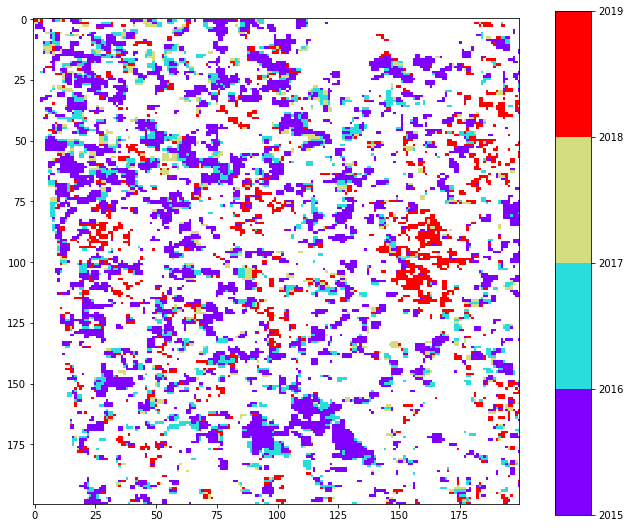

In [172]:
bins = len(idx_starts)

cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.savefig("./output/picture.png")
plt.show()


In [83]:
# #this doesn't work yet

# output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',cols, rows, 1 ,gdal.GDT_Float32)  # Open the file

# output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
# srs = osr.SpatialReference()                 # Establish its coordinate encoding
# srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
#                                              # Anyone know how to specify the 
#                                              # IAU2000:49900 Mars encoding?
# output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#                                                    # to the file
# output_raster.GetRasterBand(1).WriteArray(breaks_plot_years)   # Writes my array to the raster

# output_raster.FlushCache()

# output_raster

In [129]:
print(breaks_plot_years)
breaks_plot_years_norm = 1/(breaks_plot_years + 0.01
print(breaks_plot_years_norm)

SyntaxError: invalid syntax (<ipython-input-129-393401996a58>, line 3)

In [144]:
#cmap = plt.get_cmap("Oranges")

#cmaplist = [cmap(i) for i in range(cmap.N)]

#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# viridis = cm.get_cmap('viridis', 12)
# print(viridis)
# print(viridis(0.56))

viridis = cm.get_cmap('rainbow', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 0])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

In [171]:
from folium.plugins import FloatImage

m = folium.folium.Map(location = (latitude,longitude),tiles = "Stamen Terrain",zoom_start=13)

# if not all data is 
rows = 200
cols = 200

folium.raster_layers.ImageOverlay(
    image=breaks_plot_years_norm,
    bounds=[[latitude, longitude], [latitude + rows*ypixelsize, longitude + cols*xpixelsize]],
    colormap = newcmp
).add_to(m)
img = "output/picture.png" 
#FloatImage(encoded,bottom=5,left=5).add_to(m)

####
resolution, width, height = 75, 10,10
encoded = base64.b64encode(open("output/picture.png", 'rb').read()).decode()
from folium import IFrame

html = '<img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
popup = folium.Popup(iframe, max_width=2650)

icon = folium.Icon(color="red", icon="ok")
marker = folium.Marker(location=[latitude, longitude], popup=popup, icon=icon)
marker.add_to(m)
####

m.save(os.path.join('output/ImageOverlay_4.html'))
m